Building a recommendation system to increase customer purchases on an e-commerce platform with apriori 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Data Exploration

In [2]:
try:
    df = pd.read_csv('/Users/jerometam/Desktop/DATABASE/Online_Retail.csv', encoding='latin1')
except UnicodeDecodeError:
    print("Failed to read with 'latin1' encoding.")
    try:
        df = pd.read_csv('/Users/jerometam/Desktop/DATABASE/Online_Retail.csv', encoding='ISO-8859-1')
    except UnicodeDecodeError:
        print("Failed to read with 'ISO-8859-1' encoding.")

In [3]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [4]:
print(f'Shape : {df.shape}')

Shape : (541909, 8)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


We observe that the minimum price and quantity are negative, which is impossible, we need to rectify this discrepancy.

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Description and CustomerID contain NaN values. Description is crucial for our Apriori algorithm, so we need to investigate this issue further.

In [8]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [9]:
# Check each stock code has only one description
df.groupby('StockCode').apply(lambda x: x['Description'].unique())

StockCode
10002                          [INFLATABLE POLITICAL GLOBE , nan]
10080                      [GROOVY CACTUS INFLATABLE, nan, check]
10120                                              [DOGGY RUBBER]
10123C                               [HEARTS WRAPPING TAPE , nan]
10123G                                                      [nan]
                                      ...                        
gift_0001_20    [Dotcomgiftshop Gift Voucher £20.00, to push o...
gift_0001_30            [Dotcomgiftshop Gift Voucher £30.00, nan]
gift_0001_40                 [Dotcomgiftshop Gift Voucher £40.00]
gift_0001_50                 [Dotcomgiftshop Gift Voucher £50.00]
m                                                        [Manual]
Length: 4070, dtype: object

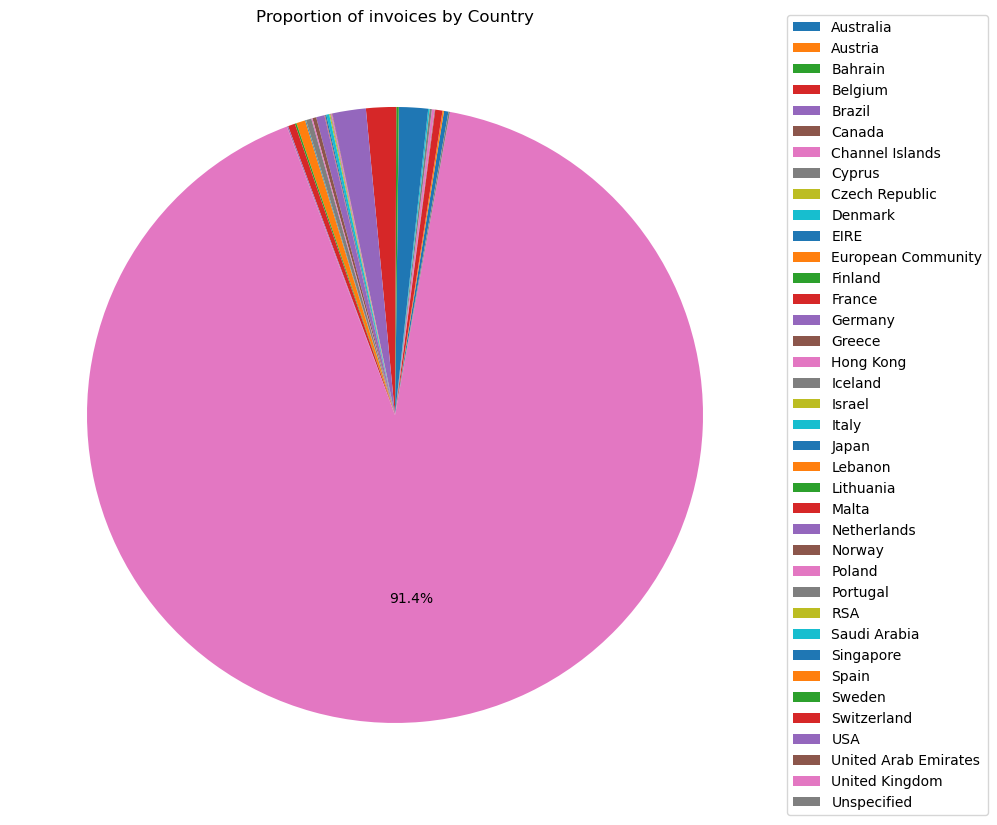

In [10]:
# Number of invoices for each country
def custom_autopct(pct):
    return '{:.1f}%'.format(pct) if pct >= 5 else ''
tmp = df.groupby(['Country'])['InvoiceNo'].count()
plt.figure(figsize=(10, 10))
plt.pie(tmp,autopct=custom_autopct, startangle=80)
plt.legend(tmp.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Proportion of invoices by Country')


plt.show()

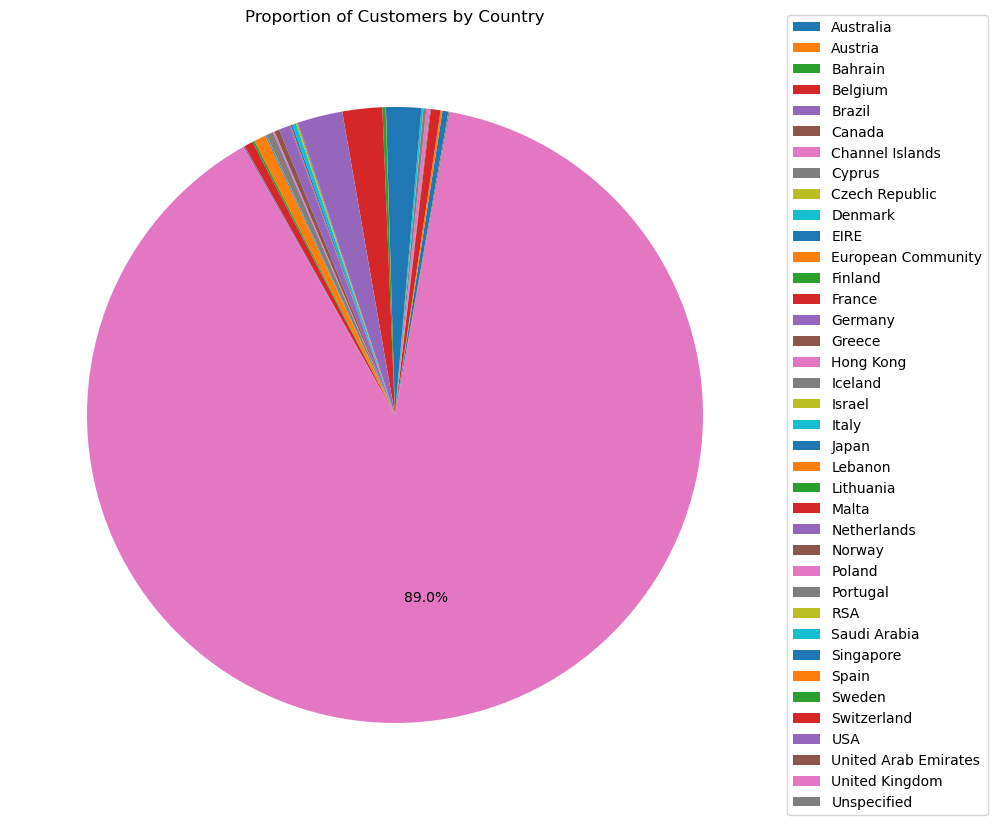

In [11]:
# Number of cusromer for each country
tmp = df.groupby(['Country']) ['CustomerID'].count()
plt.figure(figsize=(10, 10))
plt.pie(tmp,autopct=custom_autopct, startangle=80)
plt.legend(tmp.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Proportion of Customers by Country')
plt.show()

The proportion of invoices per country aligns with the customers' locations, with the UK representing the majority of the market at around 90%. This could be an important factor to consider for the recommendation model.

# Data Cleaning

In [12]:
tmp = df.dropna(subset = ['CustomerID'])
tmp.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [13]:
tmp = tmp[(tmp.Quantity >= 0) & (tmp.UnitPrice >= 0)]
tmp.describe()


,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [14]:
print(f'Len clean df: {len(tmp)}')

Len clean df: 397924


In [15]:
# From the data description we now that invoices starting with 'c' are cancelation lets check them

x = tmp['InvoiceNo'].str.startswith('c')
invoice_cancel = x.sum()
print(f'Number of concelation : {invoice_cancel}')

Number of concelation : 0


There are no cancellations.

In [16]:
# One discription for each stock code

itms = pd.DataFrame(tmp.groupby('StockCode').apply(lambda x: x['Description'].unique())).reset_index()
itms.rename(columns = { 0: 'Des'}, inplace = True)

# StockCode that have more than one Description
itms[itms['Des'].str.len() > 1]


,StockCode,Des
42,16156L,"[WRAP, CAROUSEL, WRAP CAROUSEL]"
100,17107D,"[FLOWER FAIRY,5 SUMMER B'DRAW LINERS, FLOWER F..."
118,20622,"[VIPPASSPORT COVER , VIP PASSPORT COVER ]"
170,20725,"[LUNCH BAG RED RETROSPOT, LUNCH BAG RED SPOTTY]"
262,20914,"[SET/5 RED RETROSPOT LID GLASS BOWLS, SET/5 RE..."
...,...,...
3293,85184C,"[S/4 VALENTINE DECOUPAGE HEART BOX, SET 4 VALE..."
3294,85185B,"[PINK HORSE SOCK PUPPET, PINK HORSE SOCK PUPPE..."
3357,90014A,"[SILVER/MOP ORBIT NECKLACE, SILVER M.O.P. ORBI..."
3358,90014B,"[GOLD M PEARL ORBIT NECKLACE, GOLD M.O.P. ORB..."


We notice that StockCodes with multiple descriptions are essentially the same but written differently. We will proceed by selecting only one of them.

In [17]:
def longest_string(lst):
    return max(lst, key=len)


itms['Des'] = itms['Des'].apply(longest_string)

Now we only have one description

In [18]:
# Merge clean_df with df_itms
tmp = pd.merge(tmp, itms, on = 'StockCode')
tmp = tmp.drop('Description', axis = 1)
tmp.rename(columns = { 'Des': 'Description'}, inplace = True)
tmp.head(2)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description
0,536365,85123A,6,12/1/10 8:26,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER
1,536373,85123A,6,12/1/10 9:02,2.55,17850.0,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER


# Model 

Preparing data for All Country

In [19]:
tmp2 = tmp.groupby('InvoiceNo')['Description'].apply(list).tolist()

In [20]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [21]:
te = TransactionEncoder()
te_ary = te.fit(tmp2).transform(tmp2)
transaction = pd.DataFrame(te_ary, columns=te.columns_)

In [22]:
frequent_itemsets = apriori(transaction, min_support=0.02, use_colnames=True)

In [23]:
frequent_itemsets 

,support,itemsets
0,0.030158,(3 DRAWER ANTIQUE WHITE WOOD CABINET)
1,0.021688,(3 STRIPEY MICE FELTCRAFT)
2,0.039167,(6 RIBBONS RUSTIC CHARM)
3,0.025194,(60 CAKE CASES VINTAGE CHRISTMAS)
4,0.035445,(60 TEATIME FAIRY CAKE CASES)
...,...,...
246,0.023522,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY..."
247,0.024655,"(RED HANGING HEART T-LIGHT HOLDER, WHITE HANGI..."
248,0.022659,"(REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU..."
249,0.025248,"(WOODEN FRAME ANTIQUE WHITE , WOODEN PICTURE F..."


In [24]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

In [25]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.047313,0.042566,0.028593,0.604333,14.197612,0.026579,2.419798,0.975731
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.042566,0.047313,0.028593,0.671736,14.197612,0.026579,2.902200,0.970892
2,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED ),0.033071,0.047313,0.021364,0.646003,13.653725,0.019799,2.691230,0.958457
3,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.037980,0.033233,0.022874,0.602273,18.122934,0.021612,2.430729,0.982122
4,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.033233,0.037980,0.022874,0.688312,18.122934,0.021612,3.086480,0.977300
5,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.040785,0.034258,0.024978,0.612434,17.877282,0.023581,2.491813,0.984204
6,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.034258,0.040785,0.024978,0.729134,17.877282,0.023581,3.541286,0.977552
7,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.037279,0.029996,0.024817,0.665702,22.193256,0.023698,2.901615,0.991919
8,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.029996,0.037279,0.024817,0.827338,22.193256,0.023698,5.575760,0.984471
9,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.037279,0.091929,0.020177,0.541245,5.887623,0.016750,1.979422,0.862298


In [26]:
rules.shape[0]

32

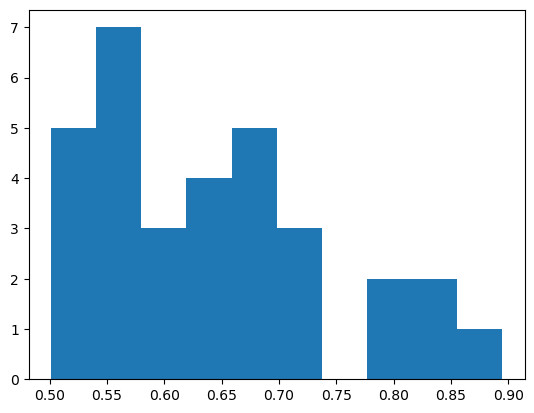

In [27]:
plt.hist(rules['confidence'])
plt.show()

In [28]:
# Show the rules that have confidance
high_confidance = rules[rules['confidence'] > 0.80]
high_confidance [['antecedents', 'consequents']]

,antecedents,consequents
8,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER)
27,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER )
29,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER)


In [29]:
high_confidance [['antecedents', 'consequents']].head(1)

,antecedents,consequents
8,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER)


Comparing with France 

In [30]:
tmp_france = tmp[tmp['Country'] == 'France']

In [31]:
tmp_france2= tmp_france.groupby('InvoiceNo')['Description'].apply(list).tolist()

In [32]:
te_ary = te.fit(tmp_france2).transform(tmp_france2)
transaction_fr = pd.DataFrame(te_ary, columns=te.columns_)

In [33]:
frequent_itemsets_fr = apriori(transaction_fr, min_support=0.02, use_colnames=True)
rules_fr = association_rules(frequent_itemsets_fr, metric="confidence", min_threshold=0.5)

In [34]:
high_confidance_fr = rules_fr[rules_fr['confidence'] > 0.80]
high_confidance_fr[['antecedents', 'consequents']]

,antecedents,consequents
2,(DOLLY GIRL BABY GIFT SET),( SPACEBOY BABY GIFT SET)
5,(10 COLOUR SPACEBOY PEN),(POSTAGE)
6,(3 PIECE SPACEBOY COOKIE CUTTER SET),(POSTAGE)
7,(36 PENCILS TUBE WOODLAND),(36 PENCILS TUBE RED RETROSPOT)
11,(60 CAKE CASES DOLLY GIRL DESIGN),(POSTAGE)
...,...,...
5876,"(SET/20 RED RETROSPOT PAPER NAPKINS , PACK OF ...","(POSTAGE, SET/6 RED SPOTTY PAPER PLATES, PACK ..."
5884,"(PACK OF 20 SKULL PAPER NAPKINS, SET/6 RED SPO...","(SET/20 RED RETROSPOT PAPER NAPKINS , POSTAGE,..."
5885,"(SET/20 RED RETROSPOT PAPER NAPKINS , PACK OF ...","(POSTAGE, SET/6 RED SPOTTY PAPER CUPS, PACK OF..."
5905,"(PACK OF 20 SKULL PAPER NAPKINS, SET/6 RED SPO...","(SET/20 RED RETROSPOT PAPER NAPKINS , POSTAGE,..."


In [35]:
high_confidance_fr[['antecedents', 'consequents']].head(1)

,antecedents,consequents
2,(DOLLY GIRL BABY GIFT SET),( SPACEBOY BABY GIFT SET)


# Conclusion

The results of apriori rules show which item is frequently purchased with other items. 

The result of using all countries is differnt than the result using a specific country like france this can be explain by the proportion of countries in the datasets lets check it with UK

In [36]:
tmp_uk = tmp[tmp['Country'] == 'United Kingdom']
tmp_uk = tmp_uk.groupby('InvoiceNo')['Description'].apply(list).tolist()

te_ary = te.fit(tmp_uk).transform(tmp_uk)
transaction_uk = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets_uk = apriori(transaction_uk, min_support=0.02, use_colnames=True)
rules_uk = association_rules(frequent_itemsets_uk, metric="confidence", min_threshold=0.5)

high_confidance_uk = rules_uk[rules_uk['confidence'] > 0.80]
high_confidance_uk[['antecedents', 'consequents']]

,antecedents,consequents
5,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER)
25,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER )
27,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER)


The association rules for the UK follow the same pattern as the entire dataset, which aligns with the fact that 90% of invoices and customers are from the UK.

We can conclude that it is better to create association rules for each country so that the e-commerce platform can effectively sell more products in each respective market.